In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import elasticite as el
import numpy as np
duration = el.get_default_args(el.EdgeGrid.render)['duration']

In [26]:
import sys
sys.path.append('..')
from scenario_line_fresnel import EdgeGrid
e = EdgeGrid(N_lame=25, grid_type='line')

In [27]:
e.lames.shape

(4, 31)

## sampling particles on the structure

In [28]:
struct = e.lames[:3, -e.struct_N:]
N_particles = e.struct_N * 2**8
particles = np.ones((5, N_particles))
for i, vec in enumerate(struct.T.tolist()):
    print(i, vec)
    N_particles_ = N_particles/e.struct_N
    x0, x1 = vec[0] - .5*e.struct_longueur*np.cos(vec[2]), vec[0] + .5*e.struct_longueur*np.cos(vec[2])
    y0, y1 = vec[1] - .5*e.struct_longueur*np.sin(vec[2]), vec[1] + .5*e.struct_longueur*np.sin(vec[2])
    particles[0, i*N_particles_:(i+1)*N_particles_] = np.linspace(x0, x1, N_particles_)
    particles[1, i*N_particles_:(i+1)*N_particles_] = np.linspace(y0, y1, N_particles_)
    

0 [-1.4488887394336025, 3.111771432346219, 3.4033920413889427]
1 [-3.5317048714782544, 1.364081184137463, 4.276056667386108]
2 [-3.853764727862665, -1.4626018975182205, 4.921828490624009]
3 [1.4488887394336025, 3.111771432346219, -0.2617993877991494]
4 [3.5317048714782544, 1.364081184137463, -1.1344640137963142]
5 [3.853764727862665, -1.4626018975182205, -1.780235837034216]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [29]:
particles

array([[ 0.  , -0.01, -0.02, ...,  3.55,  3.54,  3.54],
       [ 3.5 ,  3.5 ,  3.49, ..., -2.91, -2.92, -2.93],
       [ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.  ,  1.  ]])

In [30]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2, suppress=True)

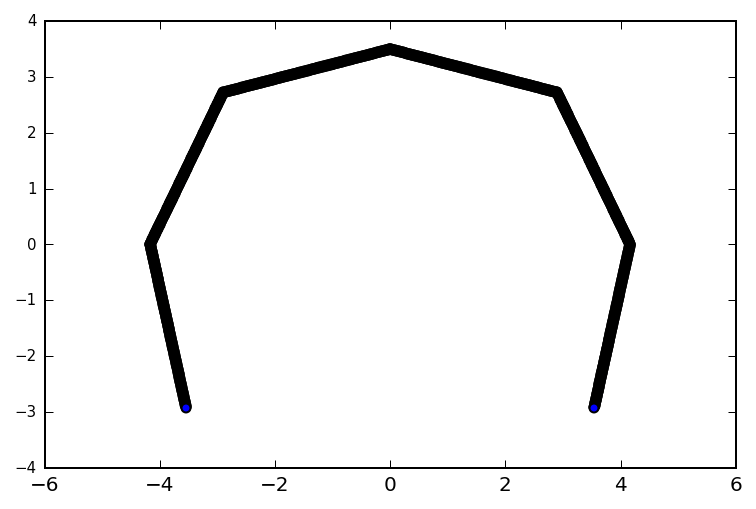

In [31]:
plt.scatter(particles[0,:], particles[1,:])

In [32]:
import MotionParticles as mp


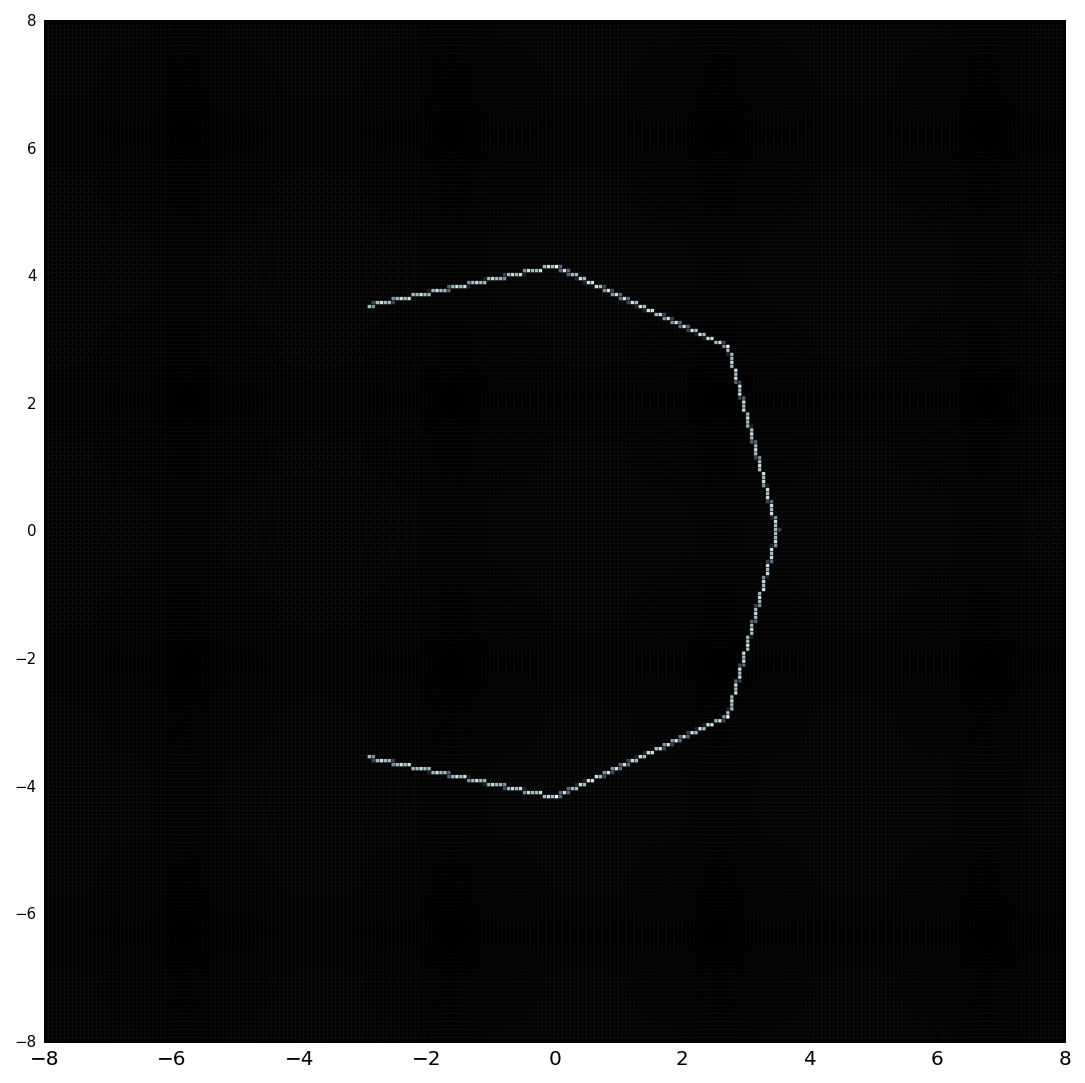

In [33]:
fig, ax = mp.spatial_readout(particles, N_X=256, N_Y=256, N_quant_x=256, N_quant_y=256, hue=False, width=e.total_width*2)

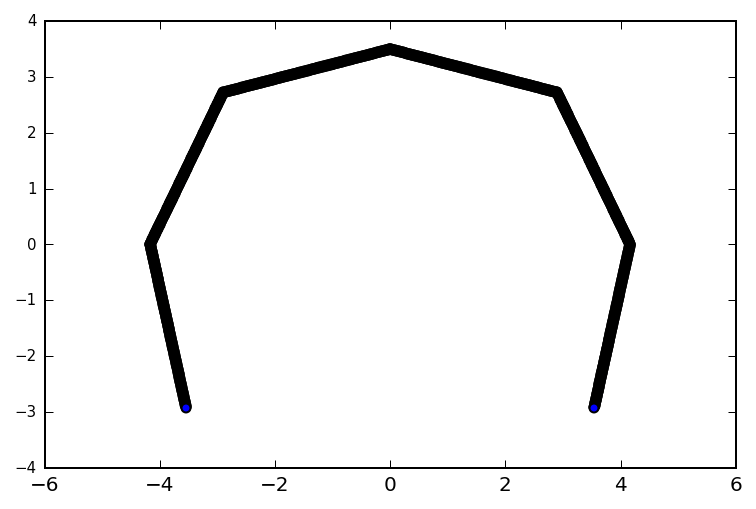

In [34]:
e.sample_structure()
plt.scatter(e.particles[0,:], e.particles[1,:])

## generating a trajectory

(-8, 8)

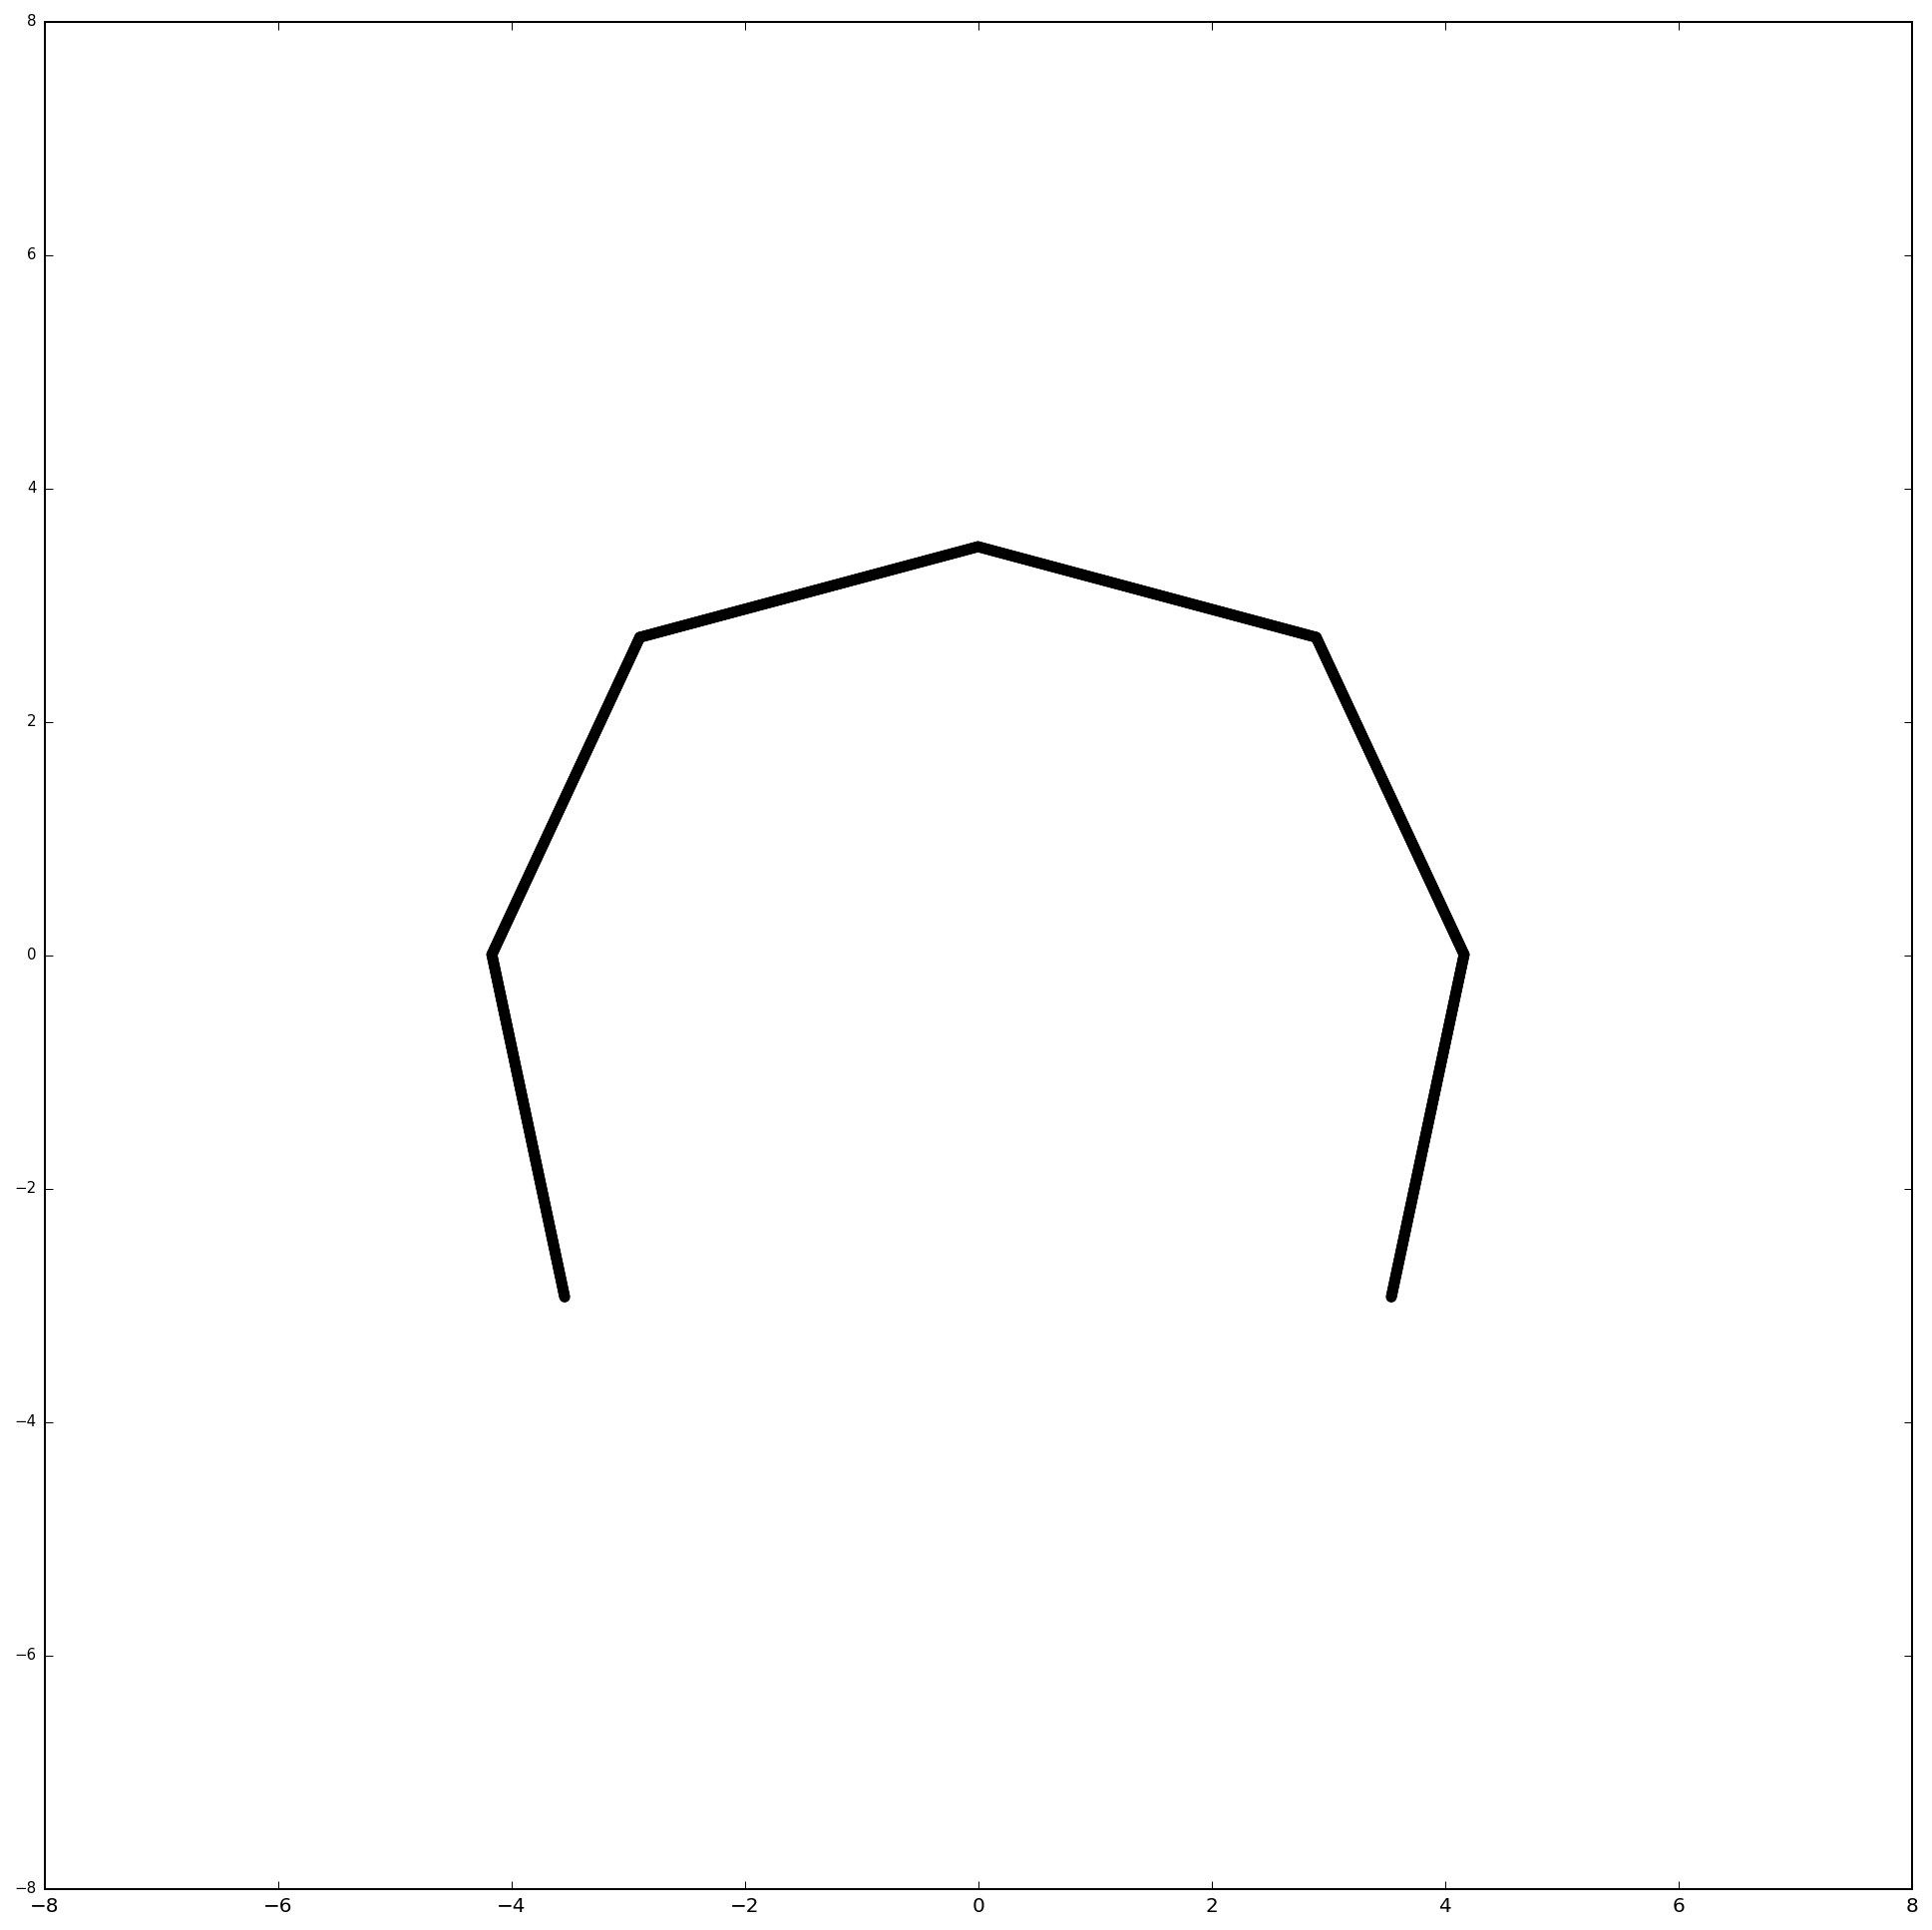

In [35]:
import elasticite as el
import numpy as np

duration = el.get_default_args(el.EdgeGrid.render)['duration']
location = el.get_default_args(el.EdgeGrid.render)['location']


class EdgeGrid(el.EdgeGrid):
    def champ(self):
        if self.structure: N_lame = self.N_lame-self.struct_N
        else: N_lame = self.N_lame
        tf = 2. #how many cycles in one period (duration)
        force = np.zeros_like(self.lames[2, :N_lame])
        damp = lambda t: 0.01 #* np.exp(np.cos(t / 6.) / 3.**2)
        xf = lambda t: location[0] - self.total_width/4.
        zf = lambda t: location[2] * (.5 + .45 * np.sin(2*np.pi*self.t*tf/duration))
        
        desired_angle = np.pi/2 + np.arctan2(self.lames[1, :N_lame]-zf(self.t), self.lames[0, :N_lame]-xf(self.t))
        self.lames[2, :N_lame] = np.mod(self.lames[2, :N_lame]-np.pi/2, np.pi) + np.pi/2
        force += np.mod(desired_angle-np.pi/2, np.pi) + np.pi/2- self.lames[2, :N_lame]
        force -= damp(self.t) * self.lames[3, :N_lame]/self.dt
        return 3. * force

e = EdgeGrid(N_lame=25, grid_type='line')
e.sample_structure()
fig = plt.figure(figsize=(e.figsize, e.figsize))
border = 0.0
ax = fig.add_axes((border, border, 1.-2*border, 1.-2*border), axisbg='w')
scat  = ax.scatter(e.particles[0,:], e.particles[1,:], c=e.particles[1,:])
ax.set_xlim([-e.total_width, e.total_width])
ax.set_ylim([-e.total_width, e.total_width])

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



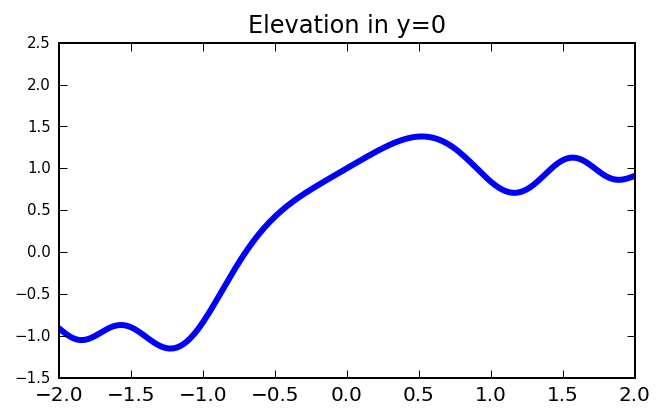

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

# DRAW A FIGURE WITH MATPLOTLIB

duration = 2

fig_mpl, ax = plt.subplots(1,figsize=(5,3), facecolor='white')
xx = np.linspace(-2,2,200) # the x vector
zz = lambda d: np.sinc(xx**2)+np.sin(xx+d) # the (changing) z vector
ax.set_title("Elevation in y=0")
ax.set_ylim(-1.5,2.5)
line, = ax.plot(xx, zz(0), lw=3)

In [37]:
fps = 25.
# ANIMATE WITH MOVIEPY (UPDATE THE CURVE FOR EACH t). MAKE A GIF.
def make_frame_mpl(t):
    line.set_ydata( zz(2*np.pi*t/duration))  # <= Update the curve
    return mplfig_to_npimage(fig_mpl) # RGB image of the figure

animation =mpy.VideoClip(make_frame_mpl, duration=duration)
animation.ipython_display(fps=fps, loop=1, autoplay=1)

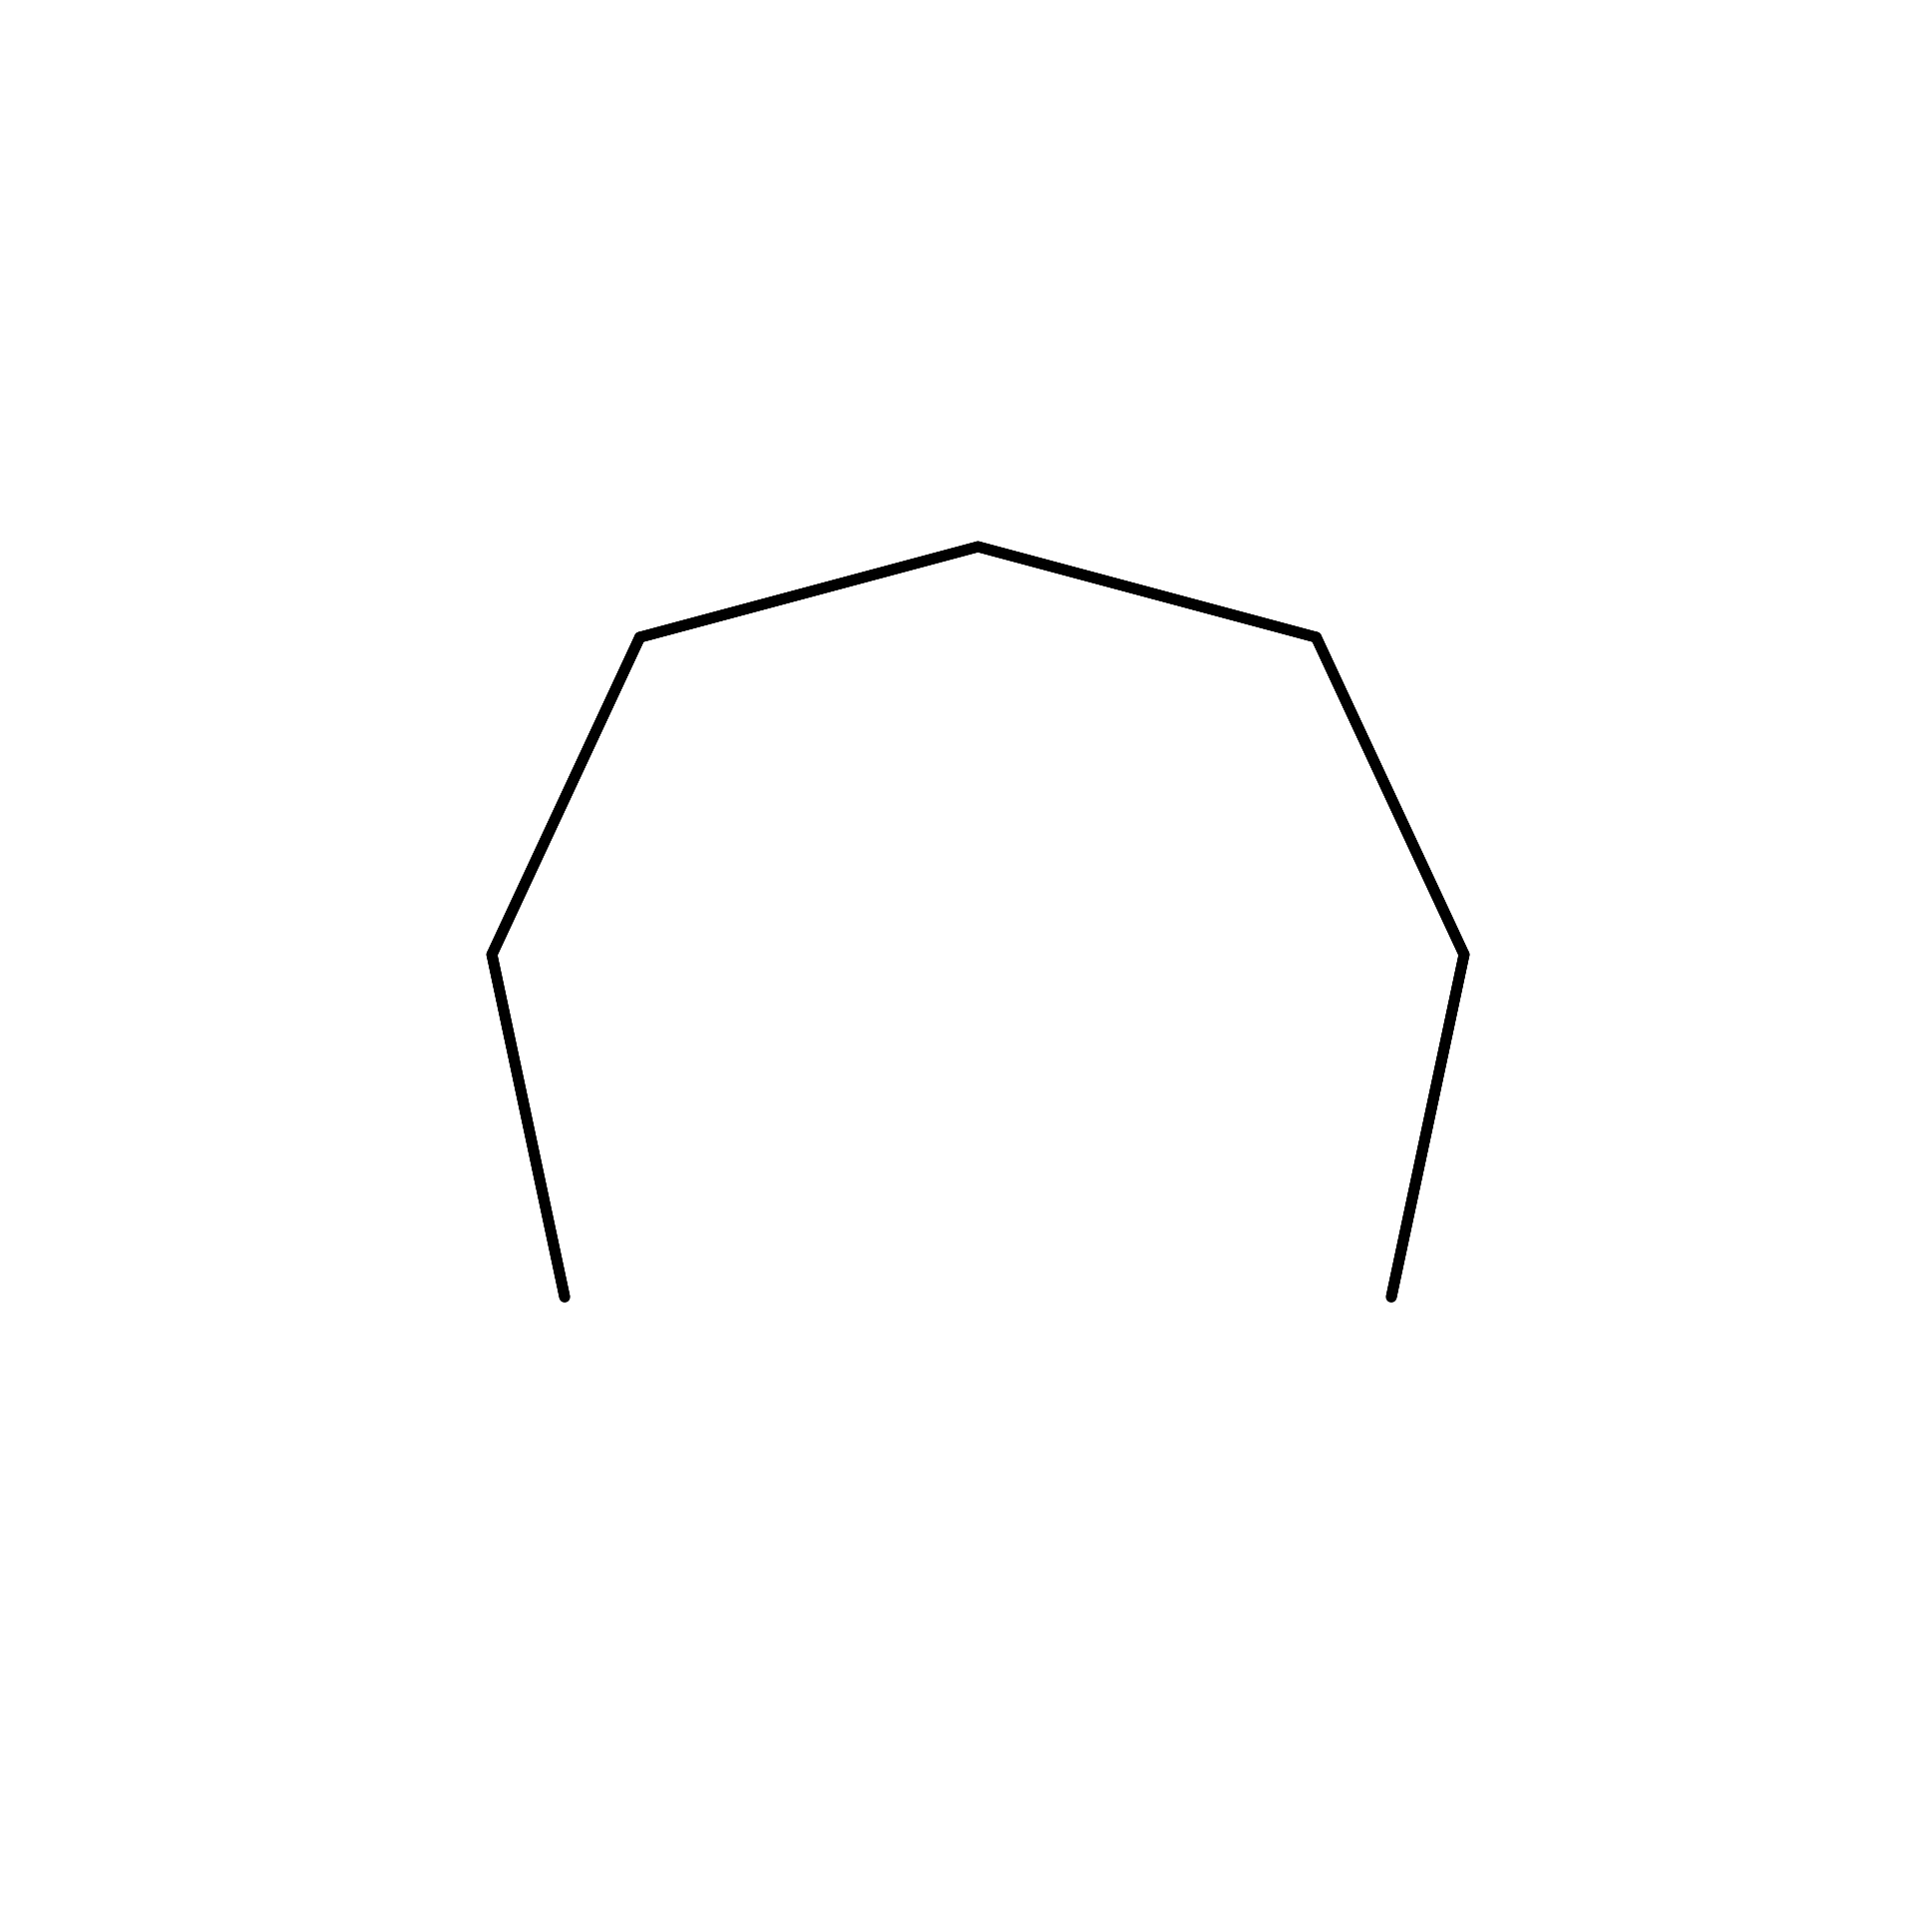

In [38]:
e = EdgeGrid(N_lame=25, grid_type='line')
e.sample_structure()
fig = plt.figure(figsize=(e.figsize, e.figsize))
border = 0.0
ax = fig.add_axes((border, border, 1.-2*border, 1.-2*border), axisbg='w')
ax.axis('off')
ax.set_xlim([-e.total_width, e.total_width])
ax.set_ylim([-e.total_width, e.total_width])
scat  = ax.scatter(e.particles[0,:], e.particles[1,:], c=e.particles[2,:])

In [39]:
fps = 10.
e.dt = 1./fps
opts = dict(vmin=0, vmax=1., linewidths=0, cmap=plt.cm.bone)
def make_frame_mpl(t):    
    #ax.clear()
    e.particles[2,:] = .5 + .5*np.sin(t*2*np.pi) 
    scat  = ax.scatter(e.particles[0,:], e.particles[1,:], c=e.particles[2,:], **opts)
    return mplfig_to_npimage(fig) # RGB image of the figure

animation = mpy.VideoClip(make_frame_mpl, duration=duration)
animation.ipython_display(fps=fps, loop=1, autoplay=1)

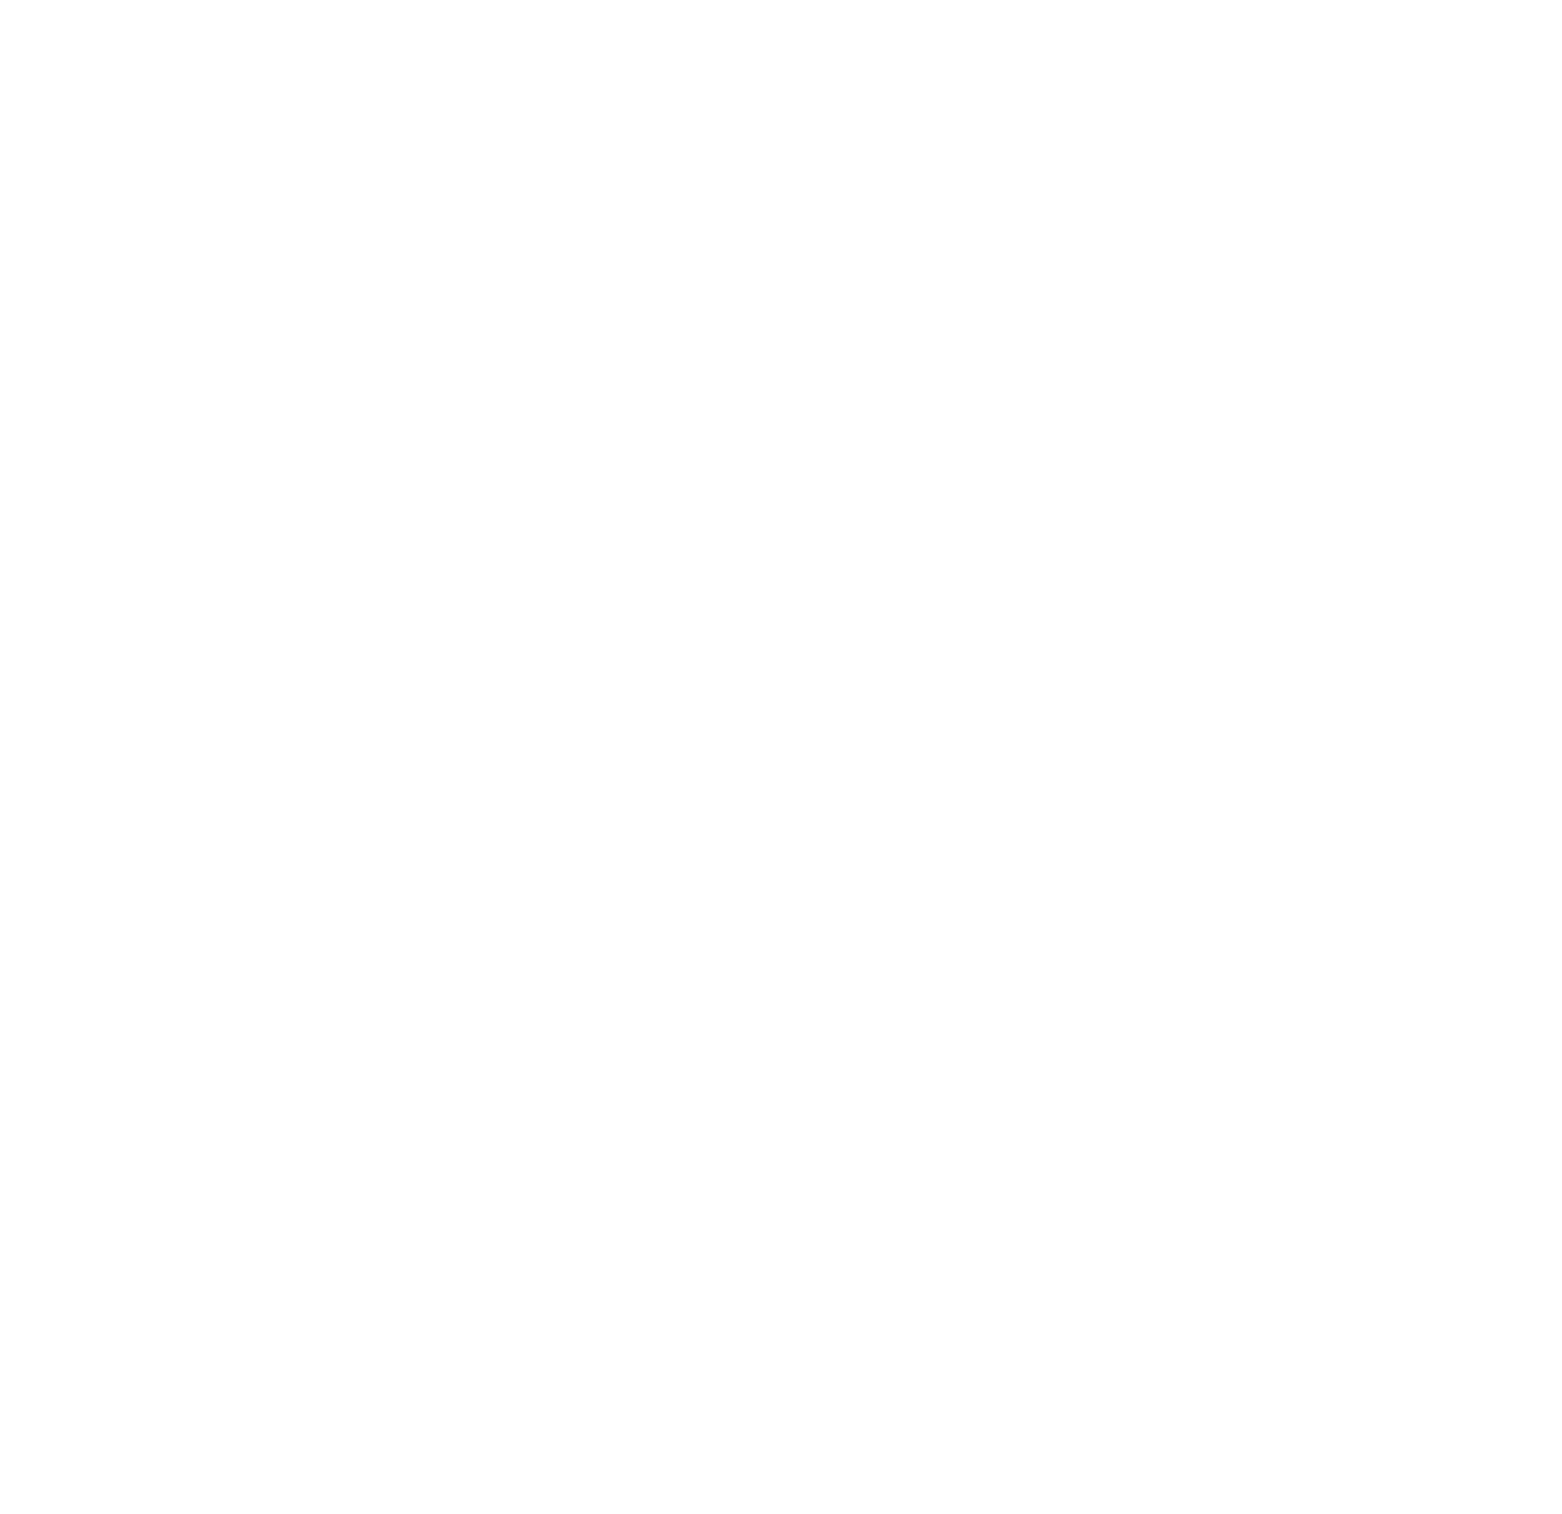

In [40]:
import elasticite as el
import numpy as np

class EdgeGrid(el.EdgeGrid):
    def update_particles(self):
        self.particles[2,:] =  .5 + .5*np.cos((self.t + np.linspace(0, 1., self.N_particles))*2*np.pi)

    def update(self):
        self.update_particles()

e = EdgeGrid(N_lame=25, grid_type='line')
fig, ax = plt.subplots(1, 1, figsize=(e.figsize, e.figsize))
ax.axis('off')
ax.set_xlim([-e.total_width, e.total_width])
ax.set_ylim([-e.total_width, e.total_width])

#ax = fig.add_axes((0, 0, 1, 1), axisbg='w')
fps = 10.
e.dt = 1./fps
opts = dict(vmin=0, vmax=1., linewidths=0, cmap=plt.cm.bone)
#print(opts)

In [41]:
def make_frame_mpl(t):    
    ax.clear()
    ax.axis('off')
    ax.set_xlim([-e.total_width, e.total_width])
    ax.set_ylim([-e.total_width, e.total_width])

    e.t = t
    e.update()
    scat  = ax.scatter(e.particles[0,:], e.particles[1,:], c=e.particles[2,:], **opts)
    return mplfig_to_npimage(fig) # RGB image of the figure

animation = mpy.VideoClip(make_frame_mpl, duration=duration)
animation.ipython_display(fps=fps, loop=1, autoplay=1)

All in one call:

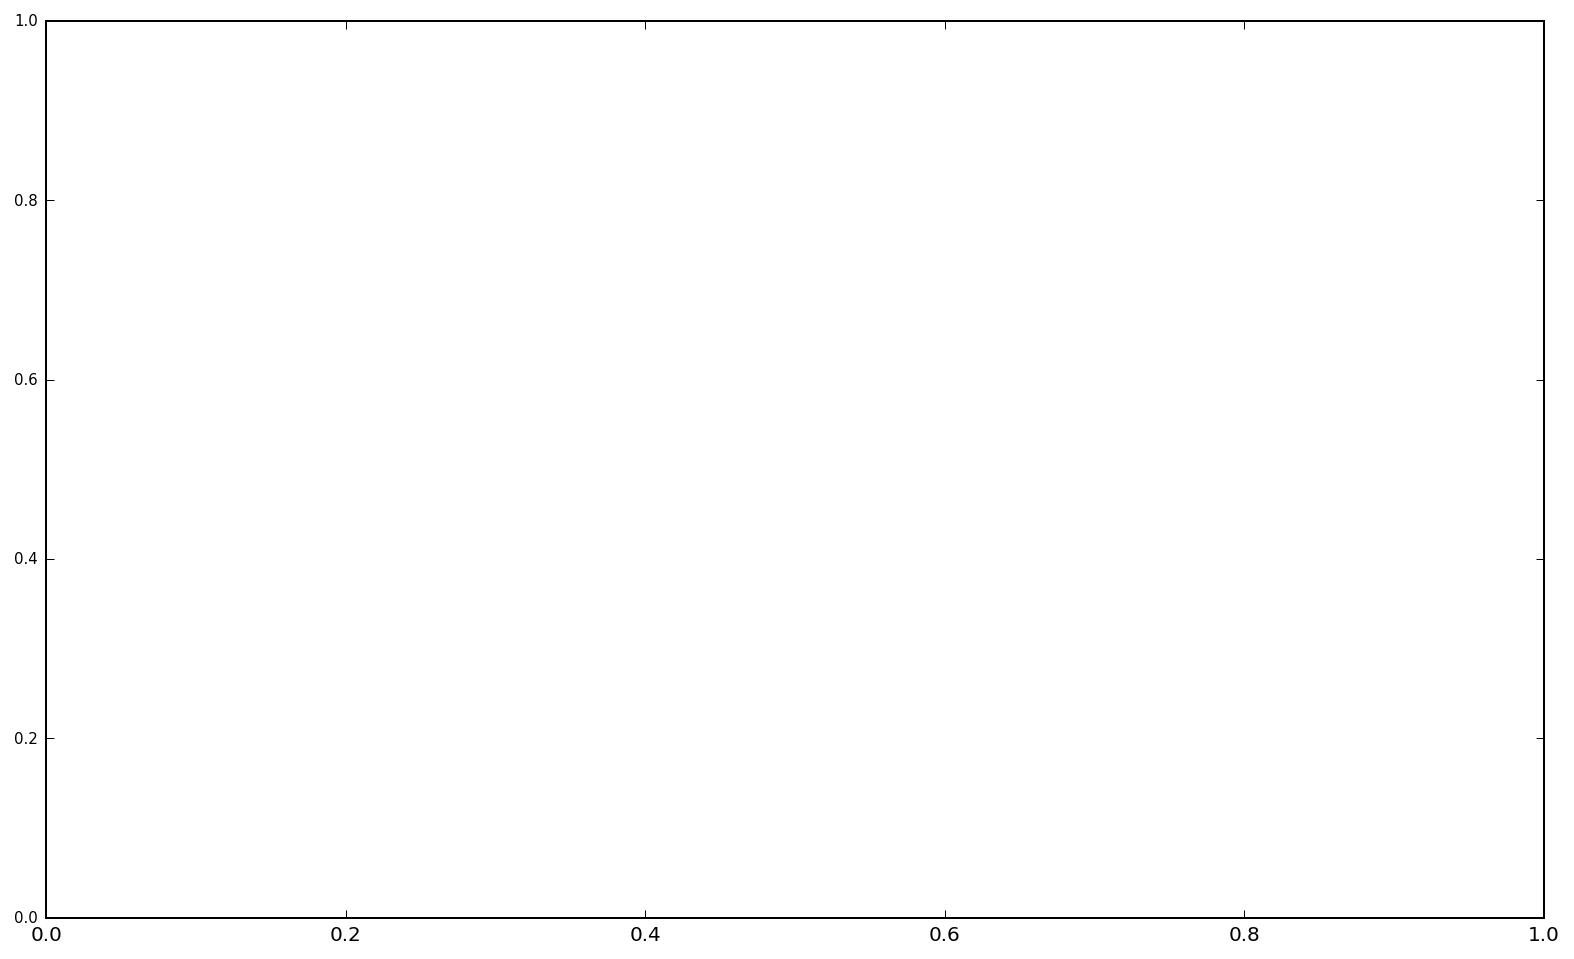

In [42]:
class EdgeGrid(el.EdgeGrid):
    def update_particles(self):
        self.particles[2,:] =  .5 + .5*np.cos((self.t + np.linspace(0, 1., self.N_particles))*2*np.pi)

    def update(self):
        self.update_particles()

e = EdgeGrid(N_lame=25, grid_type='line')
e.animate()

## git


In [43]:
!git s
#!git add 2015-10-27\ élasticité\ expansion.ipynb

 M "2015-11-02 \303\251lasticit\303\251 expansion en miroir.ipynb"
?? "../notes-Laurent/2015-10-22_\303\251lasticit\303\251 LAMES-Dynamique_pdf.pdf"
?? __temp__.mp4
?? __temp_ipython__.png
?? anim.gif
?? ../screenshot.png


In [44]:
!git commit -am' expansion - function de samples sur la structure - all in one call'

[master b516db9]  expansion - function de samples sur la structure - all in one call
 1 file changed, 436 insertions(+), 747 deletions(-)
 rewrite "posts/2015-11-02 \303\251lasticit\303\251 expansion en miroir.ipynb" (98%)


In [45]:
! git push



fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
